## Airbnb Marchine Learning


In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest

In [4]:
ruta = "/workspaces/aliasys-procesamiento-de-datos/data/raw/AB_NYC_2019.csv"

# Cargar los datos desde el enlace
total_data = pd.read_csv(ruta)

# Mostrar primeras filas
total_data.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
# Mostrar la forma del DataFrame
total_data.shape

(48895, 16)

In [6]:
# Mostrar información del DataFrame
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [7]:
# Eliminar las columnas que no son necesarias
total_data.drop(["id", "name", "host_name", "last_review", "reviews_per_month", "availability_365"], axis=1, inplace=True)

In [8]:
# Eliminar duplicados innecesarios
total_data.drop_duplicates(inplace=True)

## Observaciones:
- Cargamos el Dataset
- Nos fijamos que 'id', 'name', 'host_name', 'last_review', 'reviews_per_month y 'availability_356' no nos muestran una informacion necesaria por lo que procedemos a eliminarla.
- Procedemos tambien a elimiar los duplicados.

# Analisis univariado de las variables numéricas

In [9]:
# Eliminar filas con valores nulos
total_data.dropna(inplace=True)
# Mostrar estadísticas descriptivas
total_data.describe()


,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count
count,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,7.143982
std,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,32.952519
min,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000
25%,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,1.000000
50%,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000
75%,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.000000
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000


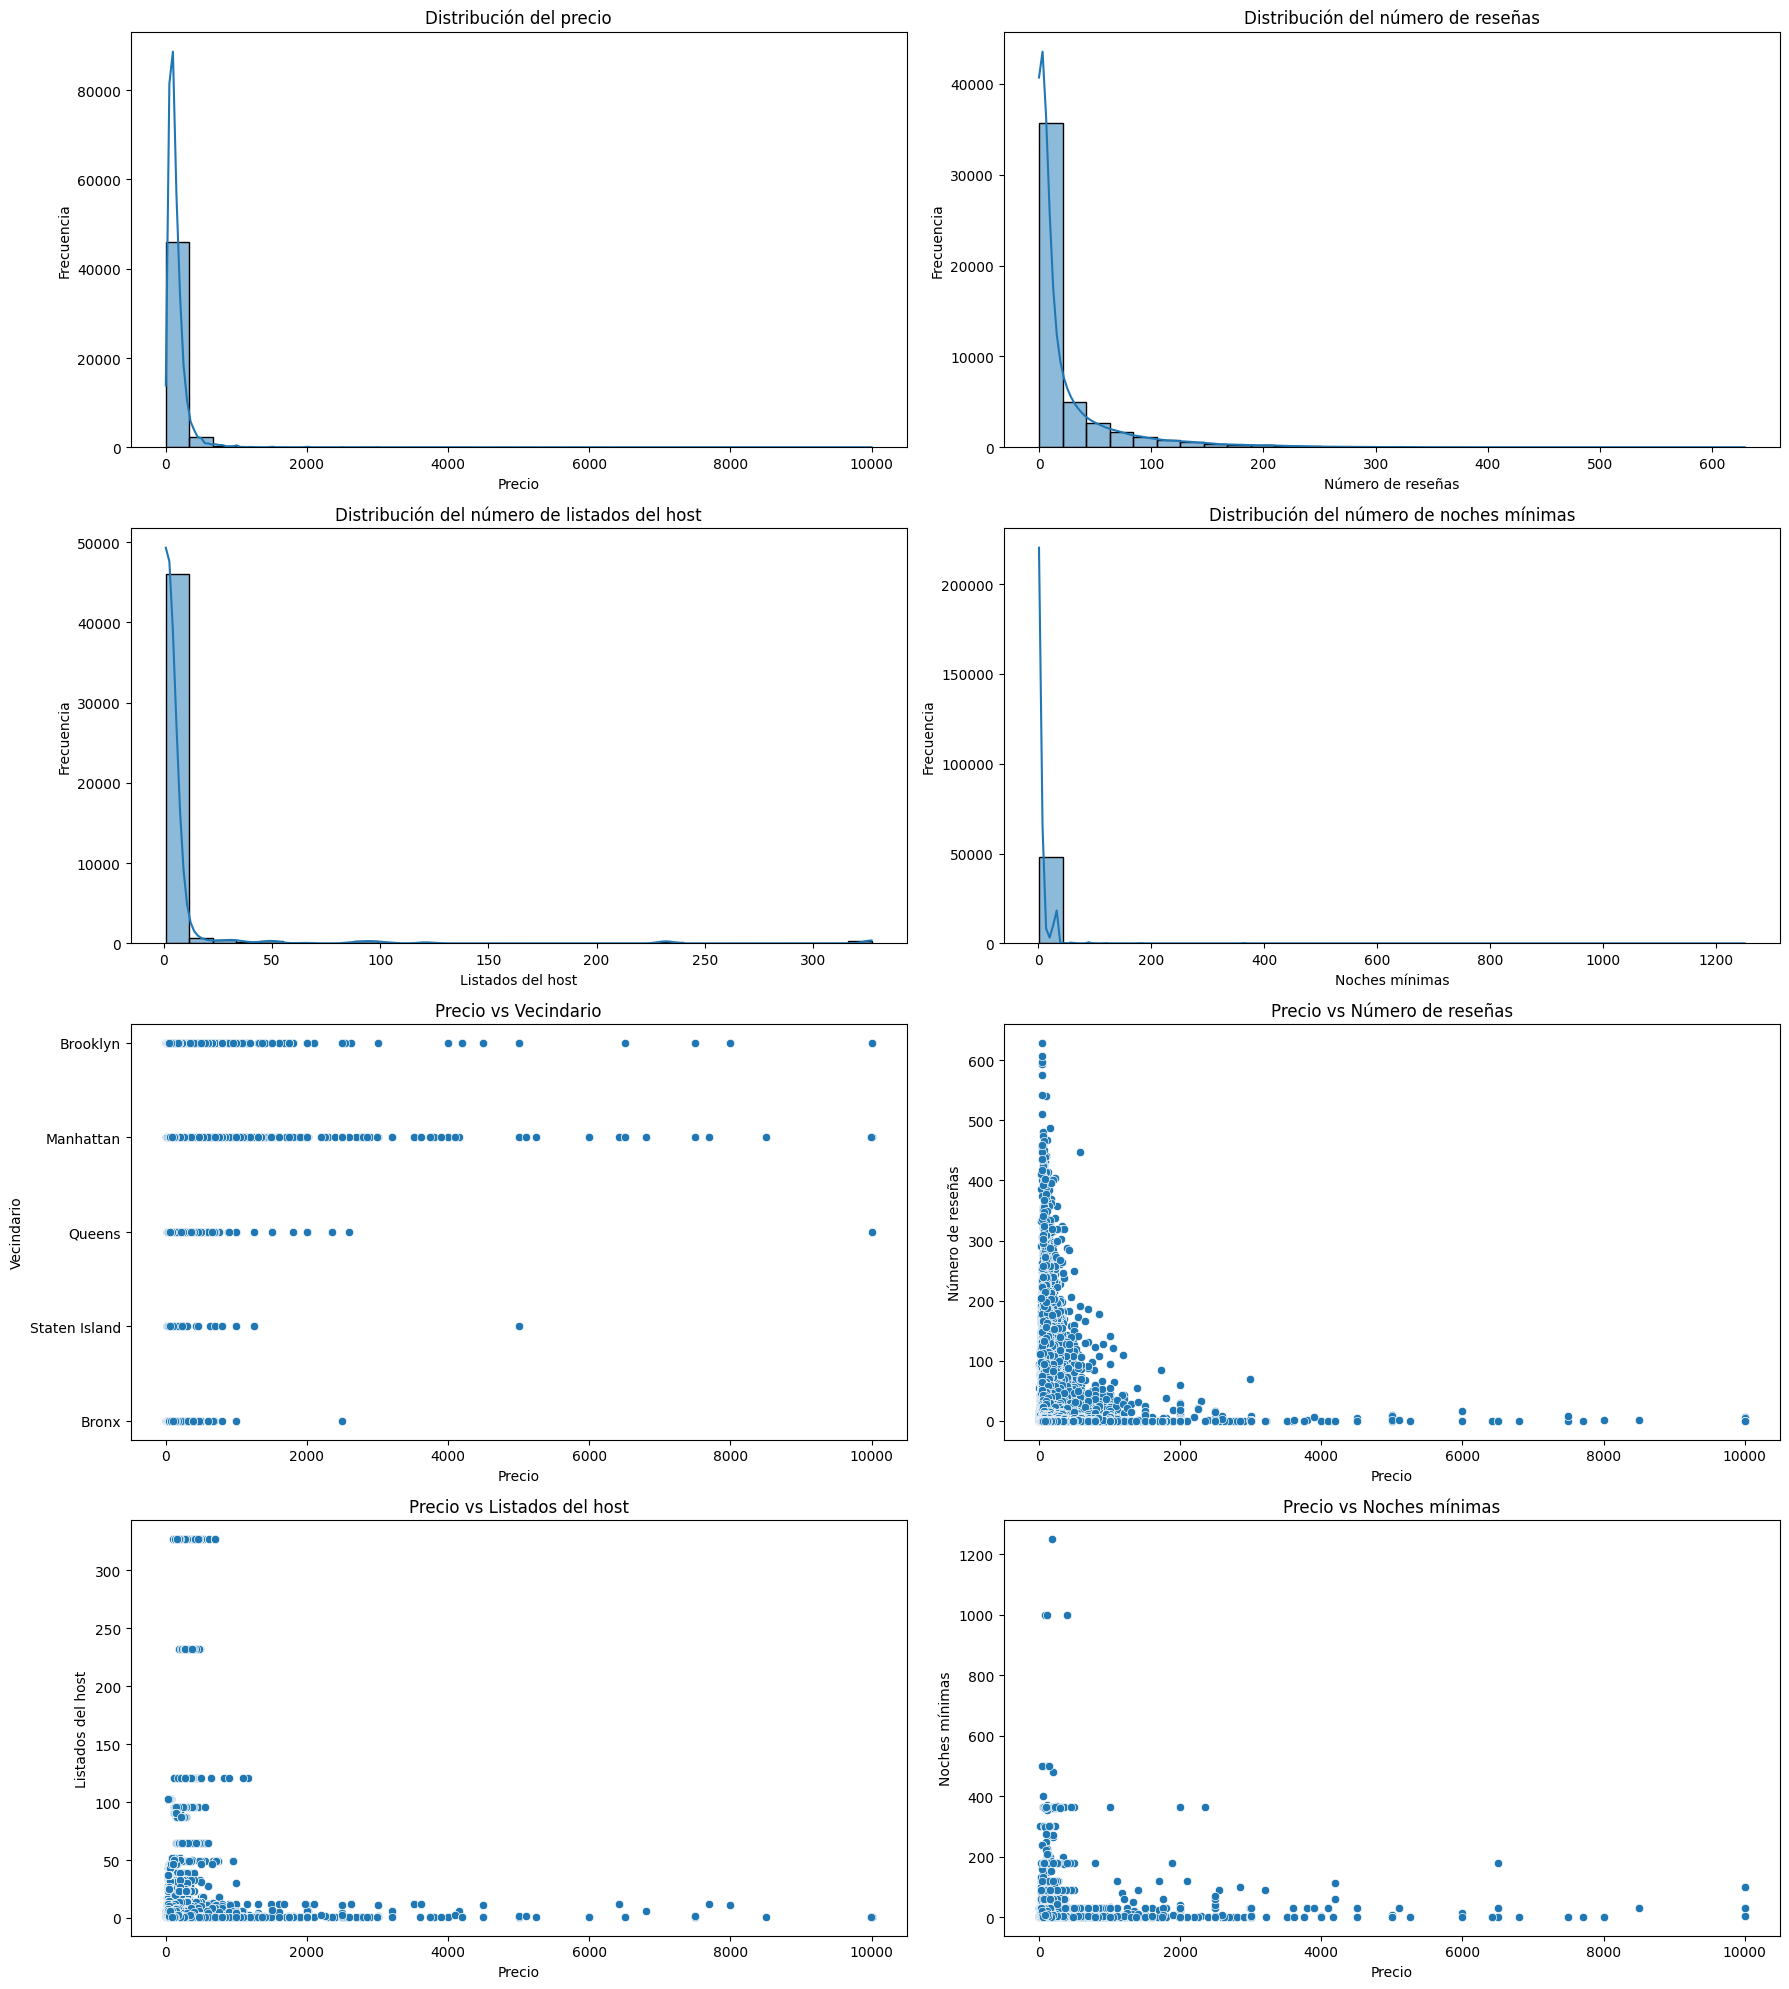

In [10]:
# Creamos un subplot con 4 filas y 2 columnas
fig, axes = plt.subplots(4, 2, figsize=(18, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Histograma: Distribución del precio
sns.histplot(data=total_data, x="price", bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribución del precio")
axes[0, 0].set_xlabel("Precio")
axes[0, 0].set_ylabel("Frecuencia")

# Histograma: Número de reseñas
sns.histplot(data=total_data, x="number_of_reviews", bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribución del número de reseñas")
axes[0, 1].set_xlabel("Número de reseñas")
axes[0, 1].set_ylabel("Frecuencia")

# Histograma: Listados del host
sns.histplot(data=total_data, x="calculated_host_listings_count", bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Distribución del número de listados del host")
axes[1, 0].set_xlabel("Listados del host")
axes[1, 0].set_ylabel("Frecuencia")

# Histograma: Noches mínimas
sns.histplot(data=total_data, x="minimum_nights", bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Distribución del número de noches mínimas")
axes[1, 1].set_xlabel("Noches mínimas")
axes[1, 1].set_ylabel("Frecuencia")

# Scatter: Precio vs Vecindario
sns.scatterplot(data=total_data, x="price", y="neighbourhood_group", ax=axes[2, 0])
axes[2, 0].set_title("Precio vs Vecindario")
axes[2, 0].set_xlabel("Precio")
axes[2, 0].set_ylabel("Vecindario")

# Scatter: Precio vs Número de reseñas
sns.scatterplot(data=total_data, x="price", y="number_of_reviews", ax=axes[2, 1])
axes[2, 1].set_title("Precio vs Número de reseñas")
axes[2, 1].set_xlabel("Precio")
axes[2, 1].set_ylabel("Número de reseñas")

# Scatter: Precio vs Listados del host
sns.scatterplot(data=total_data, x="price", y="calculated_host_listings_count", ax=axes[3, 0])
axes[3, 0].set_title("Precio vs Listados del host")
axes[3, 0].set_xlabel("Precio")
axes[3, 0].set_ylabel("Listados del host")

# Scatter: Precio vs Noches mínimas
sns.scatterplot(data=total_data, x="price", y="minimum_nights", ax=axes[3, 1])
axes[3, 1].set_title("Precio vs Noches mínimas")
axes[3, 1].set_xlabel("Precio")
axes[3, 1].set_ylabel("Noches mínimas")

plt.tight_layout()
plt.show()

# Analisis :
- El análisis univariado numérico muestra que la mayoría de los precios están concentrados en un rango bajo, con una cola larga hacia precios más altos.
- La mayoría de los listados tienen un número moderado de reseñas, y la mayoría de los hosts tienen pocos listados.
- La mayoría de los listados requieren pocas noches mínimas y tienen una alta disponibilidad durante el año.

# Analisis univariado de las variables categoricas

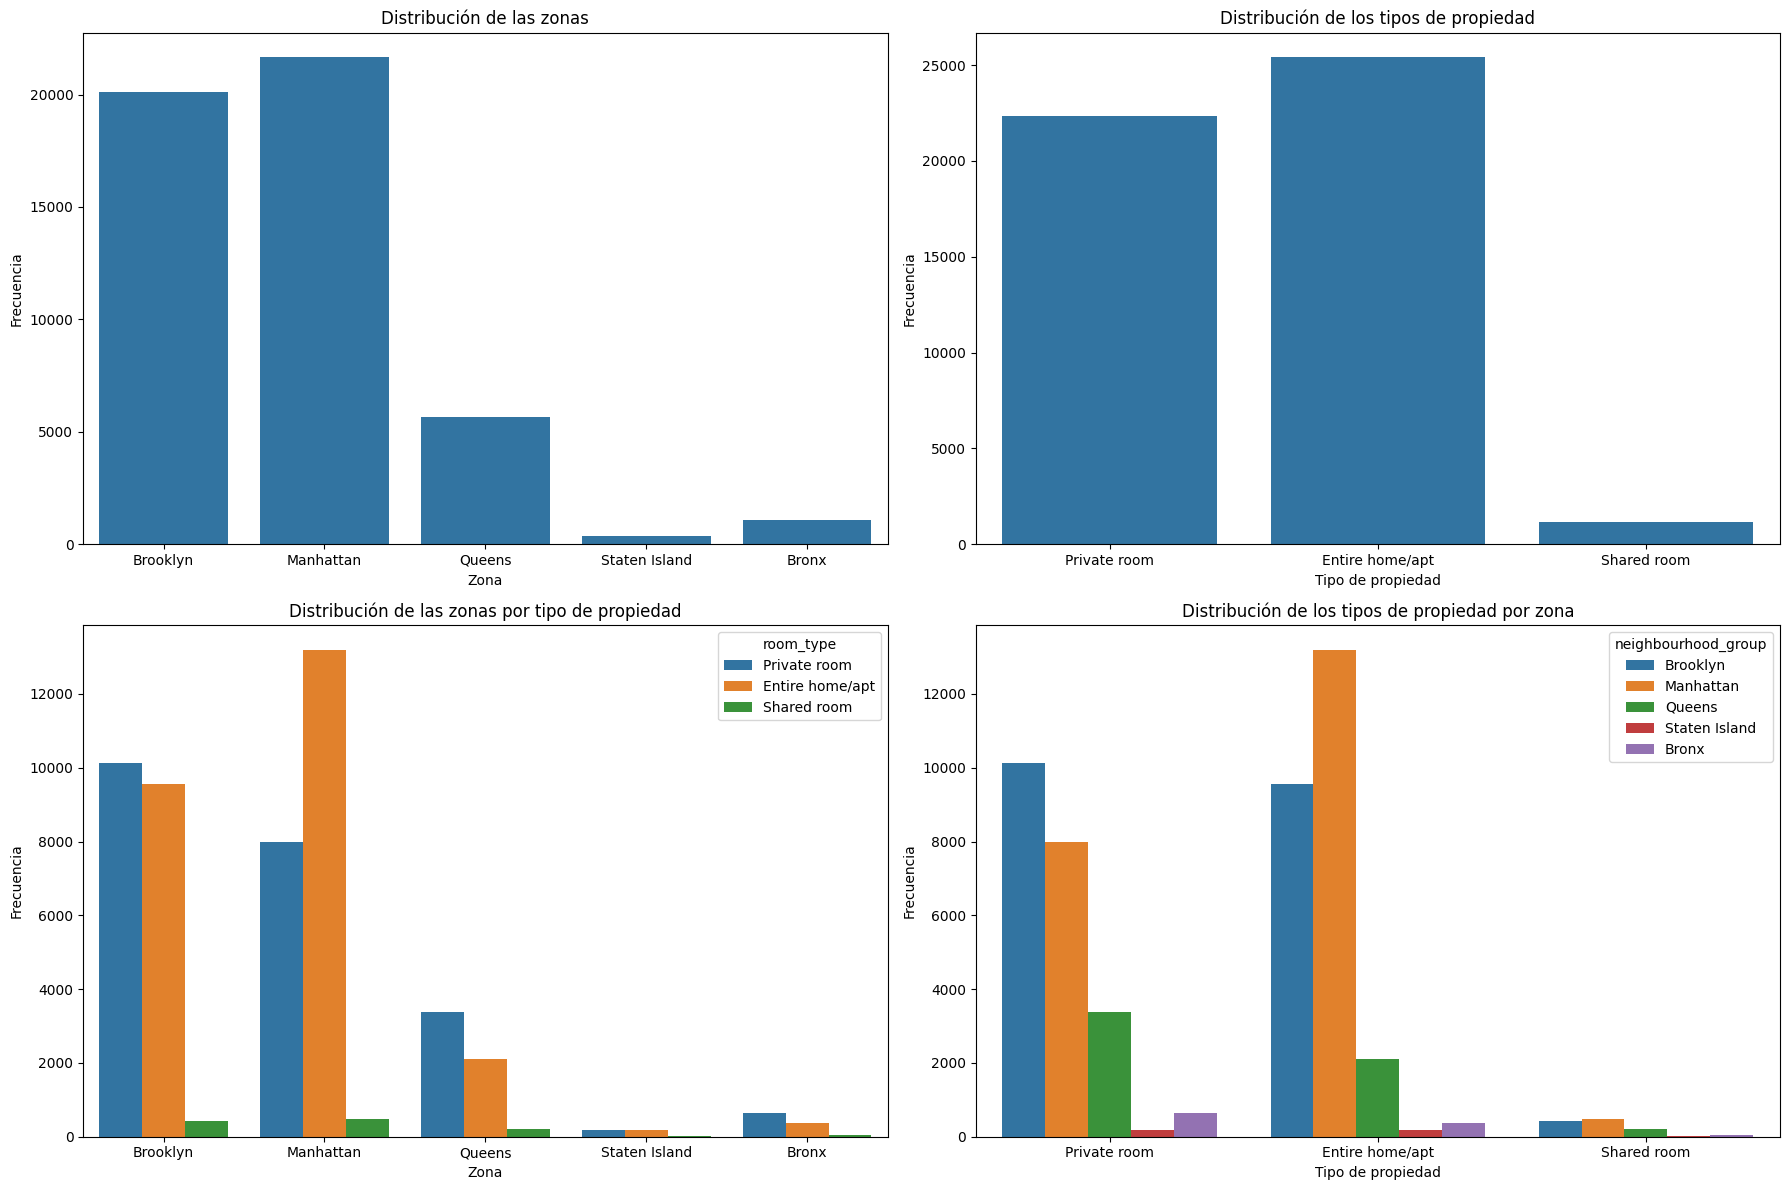

In [11]:
# Analisis univariado de las variables categóricas
# Creamos un subplot con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
# Gráfico de barras: Distribución de las zonas
sns.countplot(data=total_data, x="neighbourhood_group", ax=axes[0, 0])
axes[0, 0].set_title("Distribución de las zonas")
axes[0, 0].set_xlabel("Zona")
axes[0, 0].set_ylabel("Frecuencia")
# Gráfico de barras: Distribución de los tipos de propiedad
sns.countplot(data=total_data, x="room_type", ax=axes[0, 1])
axes[0, 1].set_title("Distribución de los tipos de propiedad")
axes[0, 1].set_xlabel("Tipo de propiedad")
axes[0, 1].set_ylabel("Frecuencia")
# Gráfico de barras: Distribución de las zonas por tipo de propiedad
sns.countplot(data=total_data, x="neighbourhood_group", hue="room_type", ax=axes[1, 0])
axes[1, 0].set_title("Distribución de las zonas por tipo de propiedad")
axes[1, 0].set_xlabel("Zona")
axes[1, 0].set_ylabel("Frecuencia")
# Gráfico de barras: Distribución de los tipos de propiedad por zona
sns.countplot(data=total_data, x="room_type", hue="neighbourhood_group", ax=axes[1, 1])
axes[1, 1].set_title("Distribución de los tipos de propiedad por zona")
axes[1, 1].set_xlabel("Tipo de propiedad")
axes[1, 1].set_ylabel("Frecuencia")
plt.tight_layout()
plt.show()



# Analisis:
- La mayoría de los listados se encuentran en Manhattan, seguido por Brooklyn.
- La mayoría de los tipos de propiedad son "Entire home/apt" y "Private room".
- La distribución de los tipos de propiedad es bastante equilibrada entre "Entire home/apt" y "Private room", con una menor proporción de "Shared room".
- La mayoría de los listados en Manhattan son "Entire home/apt", mientras que en Brooklyn hay una mayor proporción de "Private room".
- La mayoría de los listados en Queens son "Entire home/apt", mientras que en Bronx y Staten Island hay una mayor proporción de "Private room".

# Analizammos bivariados entre variables numéricas y categóricas

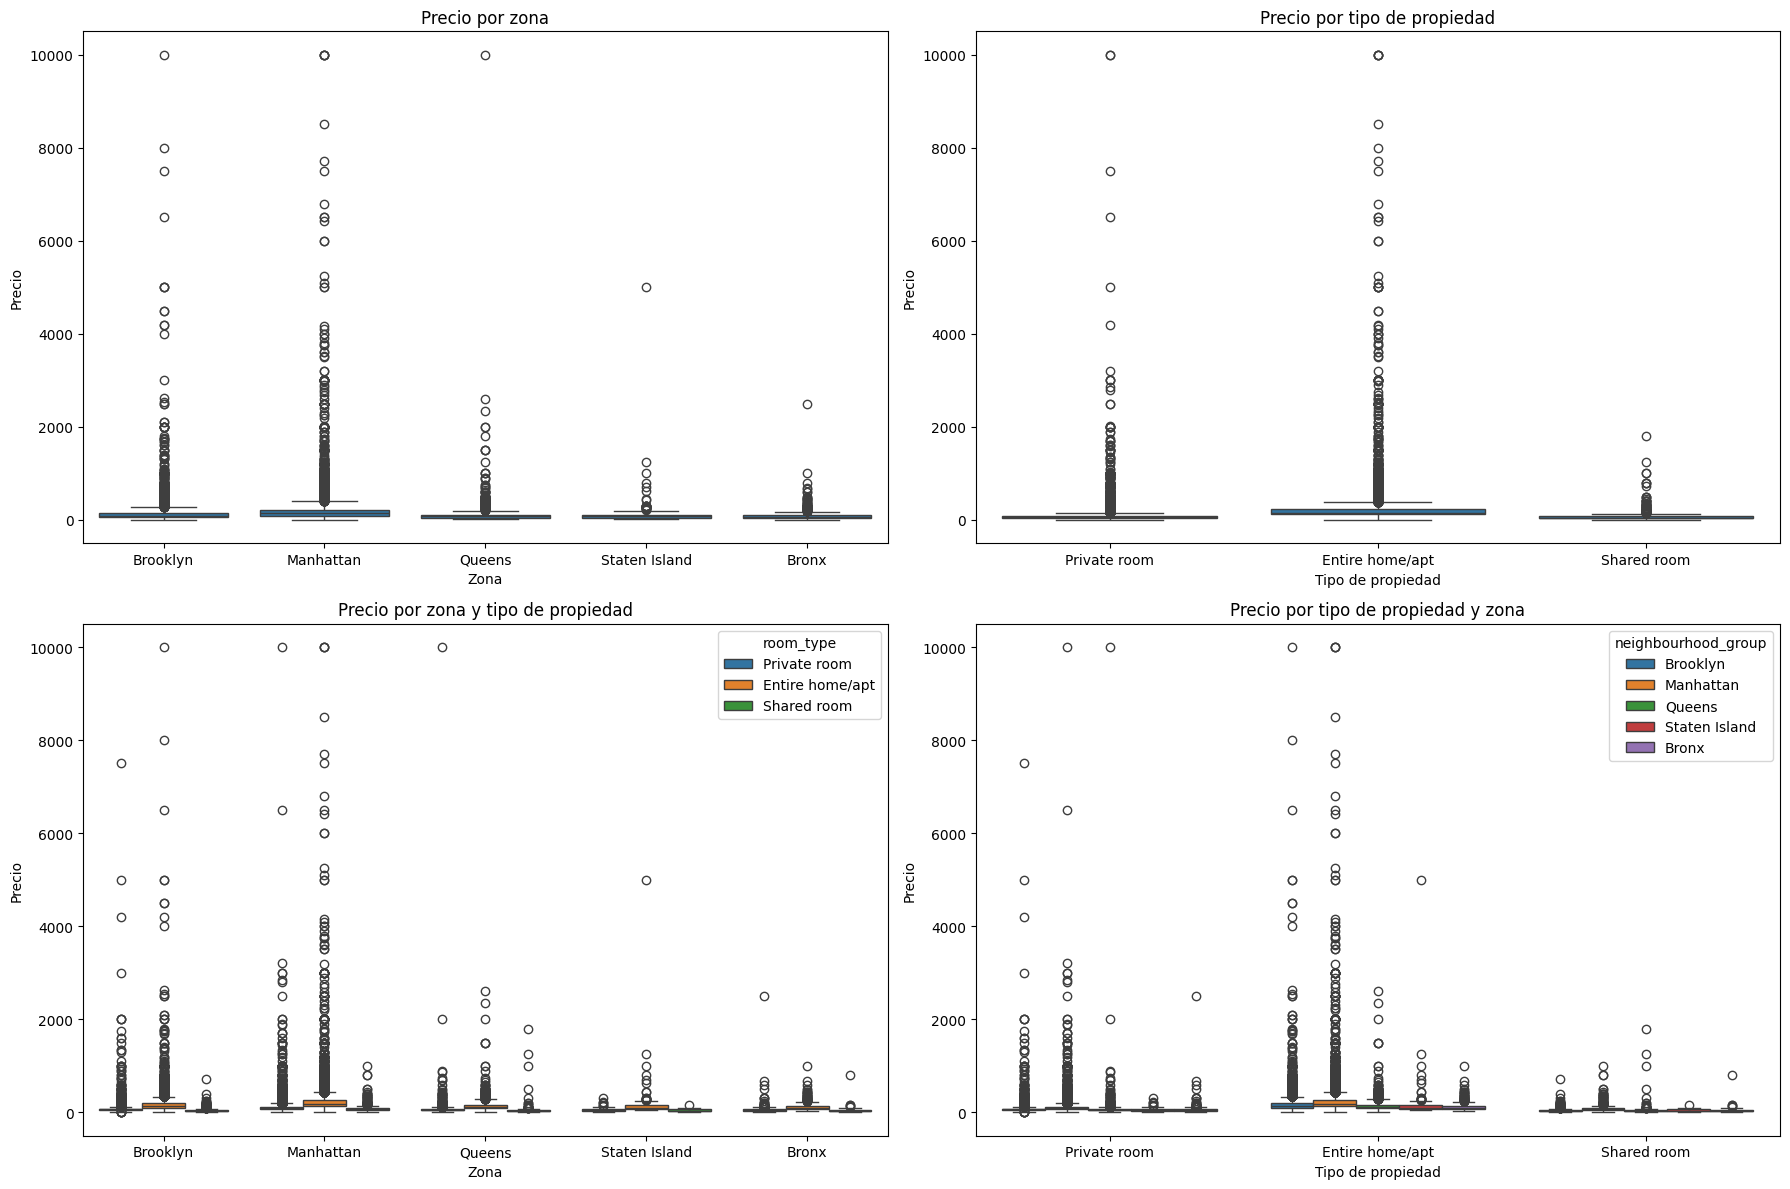

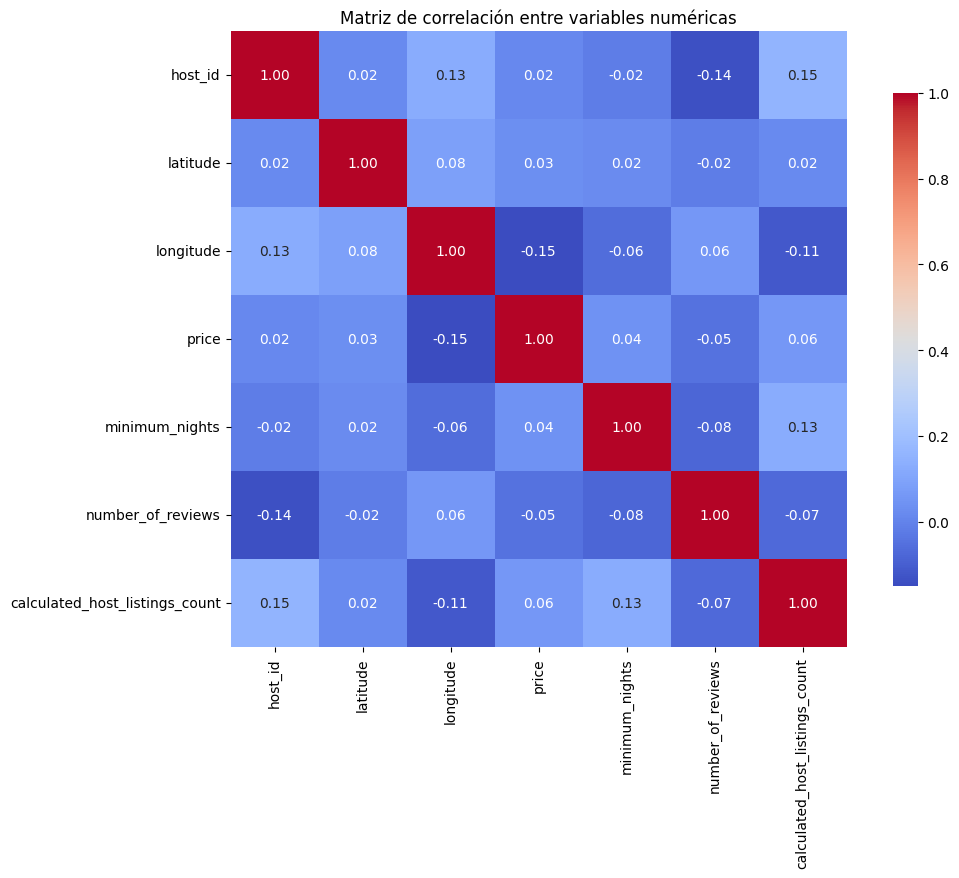

In [12]:
# Analizammos bivariados entre variables numéricas y categóricas
# Creamos un subplot con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
# Boxplot: Precio por zona
sns.boxplot(data=total_data, x="neighbourhood_group", y="price", ax=axes[0, 0])
axes[0, 0].set_title("Precio por zona")
axes[0, 0].set_xlabel("Zona")
axes[0, 0].set_ylabel("Precio")
# Boxplot: Precio por tipo de propiedad
sns.boxplot(data=total_data, x="room_type", y="price", ax=axes[0, 1])
axes[0, 1].set_title("Precio por tipo de propiedad")
axes[0, 1].set_xlabel("Tipo de propiedad")
axes[0, 1].set_ylabel("Precio")
# Boxplot: Precio por zona y tipo de propiedad
sns.boxplot(data=total_data, x="neighbourhood_group", y="price", hue="room_type", ax=axes[1, 0])
axes[1, 0].set_title("Precio por zona y tipo de propiedad")
axes[1, 0].set_xlabel("Zona")
axes[1, 0].set_ylabel("Precio")
# Boxplot: Precio por tipo de propiedad y zona
sns.boxplot(data=total_data, x="room_type", y="price", hue="neighbourhood_group", ax=axes[1, 1])
axes[1, 1].set_title("Precio por tipo de propiedad y zona")
axes[1, 1].set_xlabel("Tipo de propiedad")
axes[1, 1].set_ylabel("Precio")
plt.tight_layout()
plt.show()

# Calculamos la matriz de correlación
correlation_matrix = total_data.select_dtypes(include='number').corr()
# Visualizamos la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

# Conclusion: 
- El análisis exploratorio de datos revela que los precios de los listados en Nueva York varían significativamente según la zona y el tipo de propiedad.
- Manhattan y Brooklyn tienen los precios más altos, mientras que Staten Island tiene los precios más bajos.
- Los apartamentos privados tienden a tener precios más altos que las habitaciones compartidas o los alojamientos enteros.
- La mayoría de los listados tienen un número moderado de reseñas, y la mayoría de los hosts tienen pocos listados.
- La mayoría de los listados requieren pocas noches mínimas y tienen una alta disponibilidad durante el año.
- El análisis de correlación muestra que hay una correlación positiva moderada entre el precio y el número de reseñas, así como entre el precio y la disponibilidad.

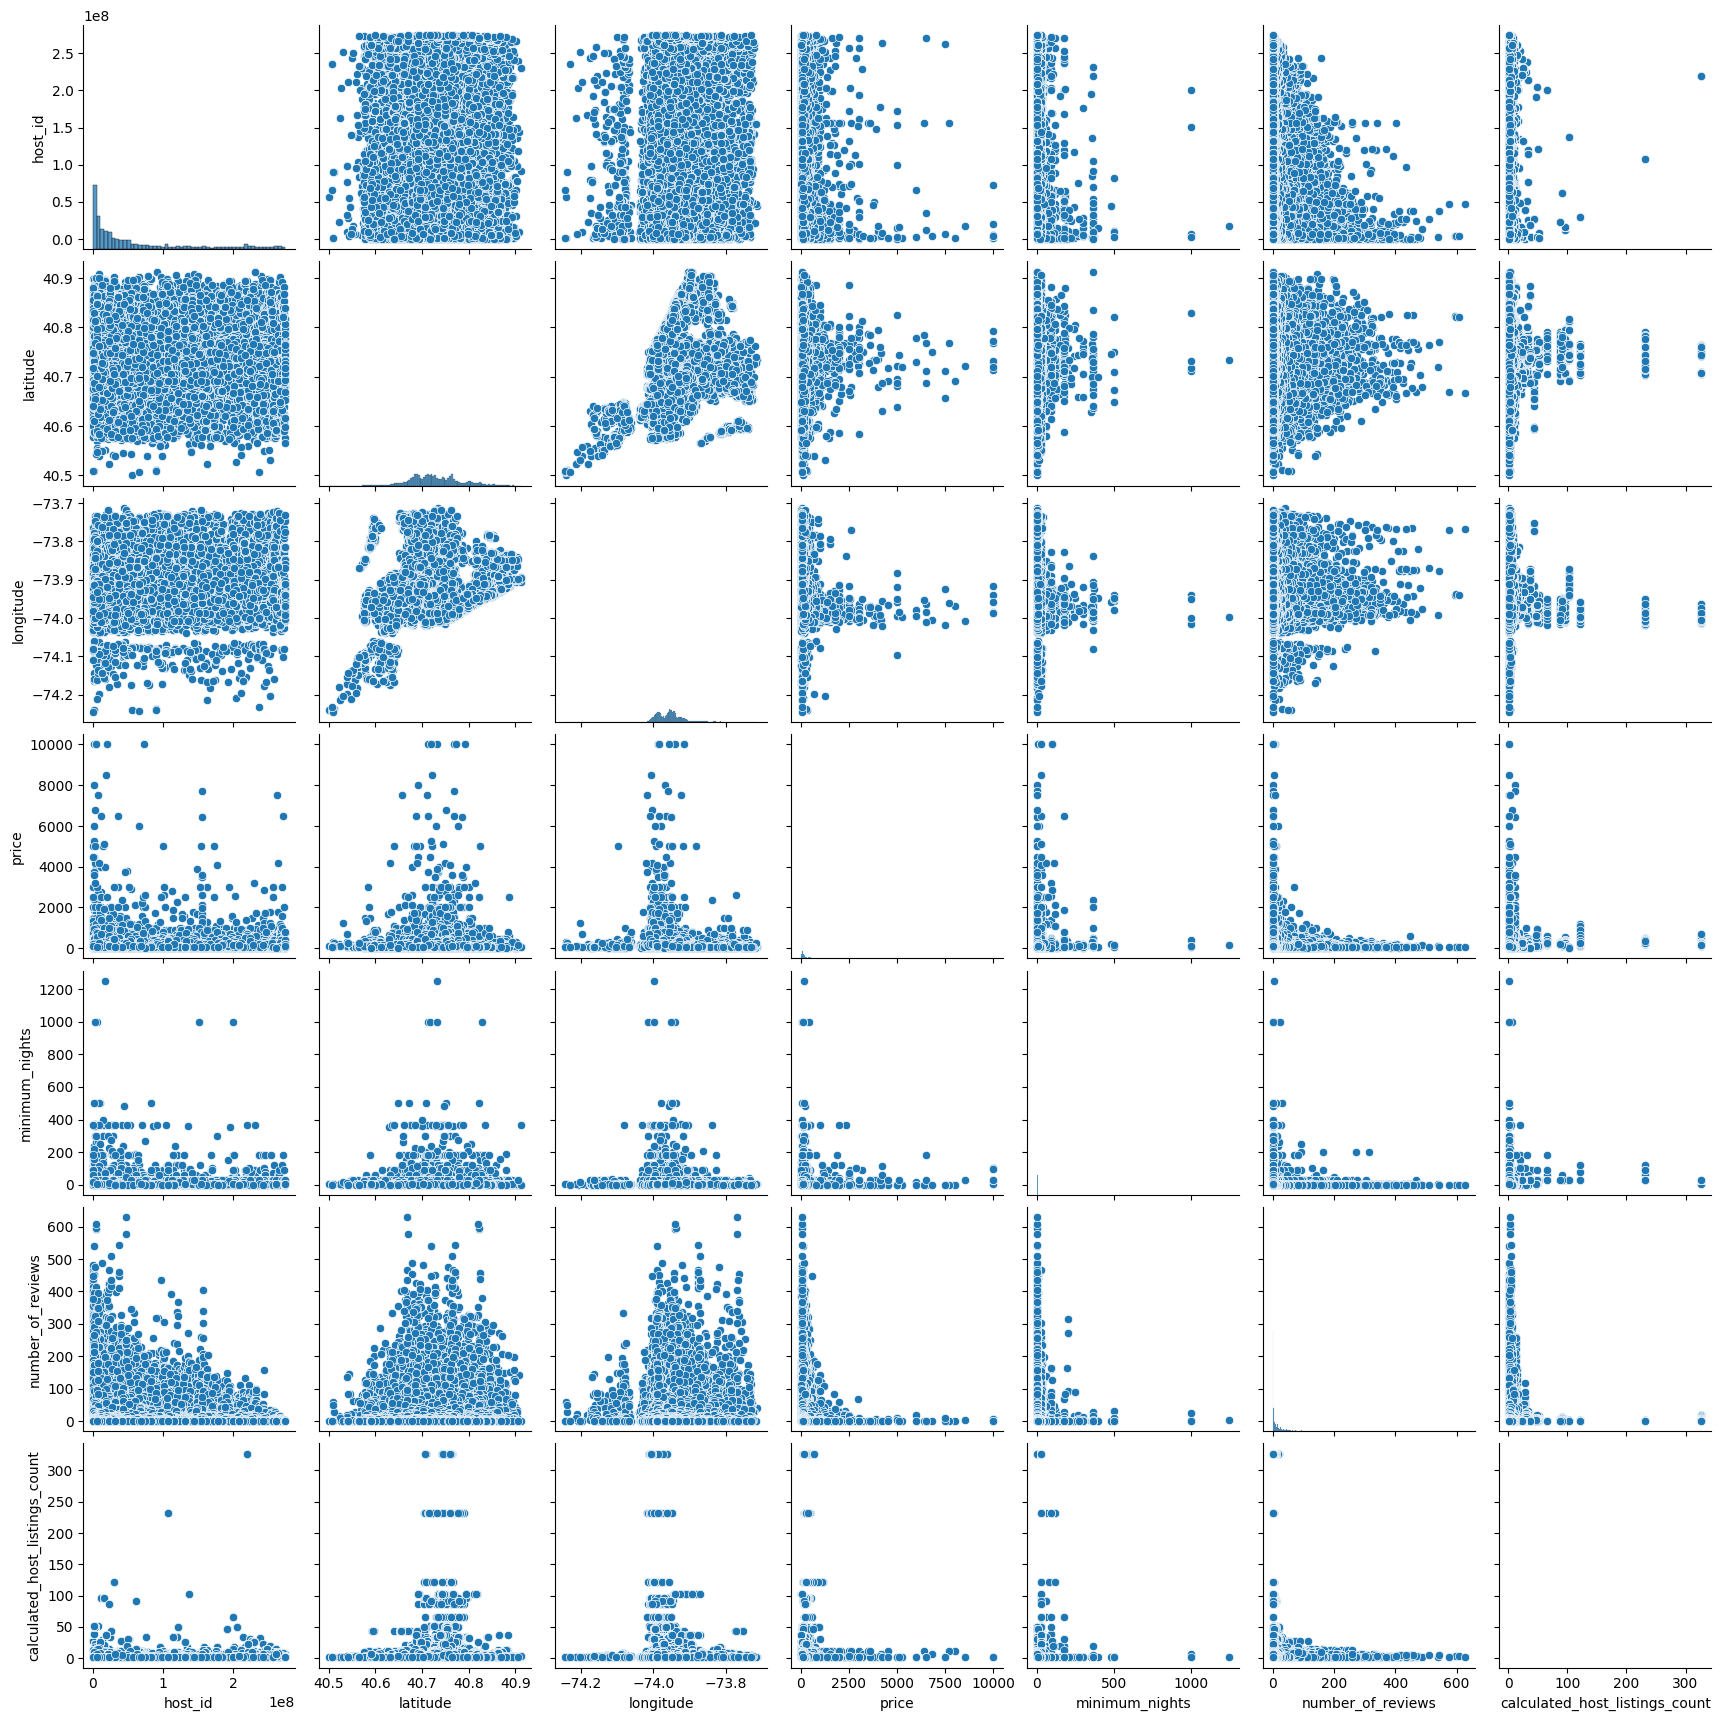

In [13]:
sns.pairplot(data=total_data)



## Paso 2

# Ingenieria de caracteristicas

In [14]:
# Transformamos las columnas con datos categóricos a  numéricos
total_data['neighbourhood_group_num'] = pd.factorize(total_data['neighbourhood_group'])[0]
total_data['room_type_num'] = pd.factorize(total_data['room_type'])[0]
total_data['neighbourhood_num'] = pd.factorize(total_data['neighbourhood'])[0]


In [15]:
total_data.drop(['neighbourhood_group', 'room_type', 'neighbourhood',], axis=1, inplace=True)
# Mostramos las primeras filas del DataFrame transformado
total_data.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,neighbourhood_group_num,room_type_num,neighbourhood_num
0,2787,40.64749,-73.97237,149,1,9,6,0,0,0
1,2845,40.75362,-73.98377,225,1,45,2,1,1,1
2,4632,40.80902,-73.94190,150,3,0,1,1,0,2
3,4869,40.68514,-73.95976,89,1,270,1,0,1,3
4,7192,40.79851,-73.94399,80,10,9,1,1,1,4


## Observaciones: 
- Transformamos los datos categoricos a numeriscos para poder trabajar con ellos.

# Analisis de outliers

In [16]:
total_data.describe(include='all')

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,neighbourhood_group_num,room_type_num,neighbourhood_num
count,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,7.143982,0.786911,0.567113,29.888782
std,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,32.952519,0.844386,0.541249,34.676634
min,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,1.000000,0.000000,0.000000,7.500000
50%,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000,1.000000,1.000000,19.000000
75%,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.000000,1.000000,1.000000,37.000000
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000,4.000000,2.000000,220.000000


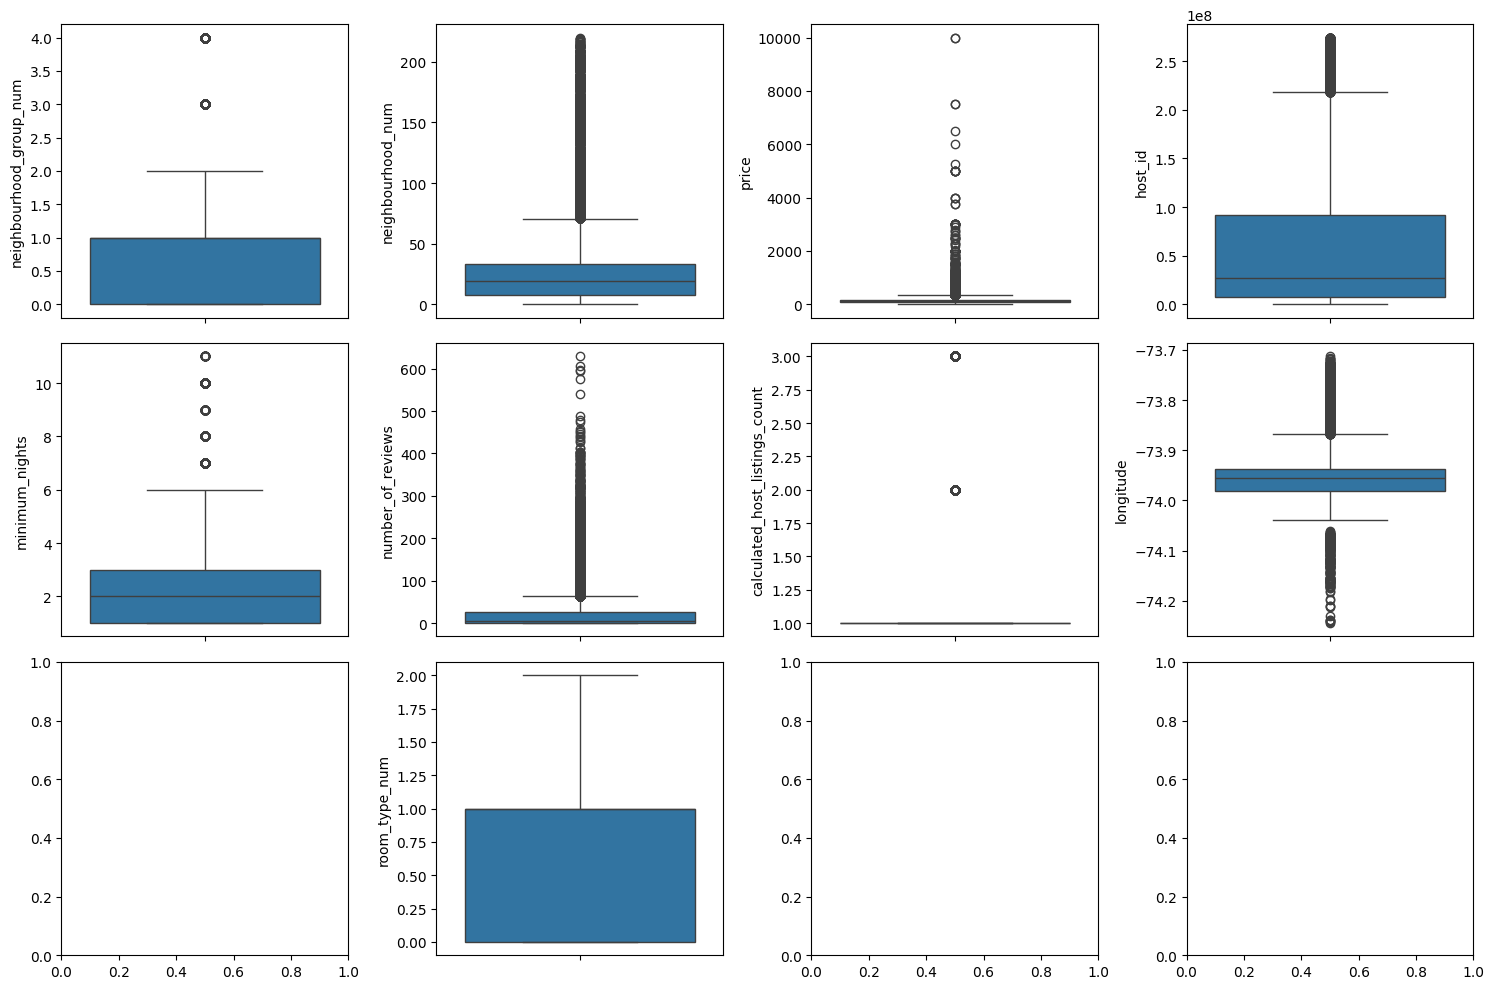

In [41]:
# Creamos subplots para detectar valores atípicos
fig, axis = plt.subplots(3, 4, figsize=(15, 10))

sns.boxplot(ax = axis[0, 0], data = total_data, y = "neighbourhood_group_num")
sns.boxplot(ax = axis[0, 1], data = total_data, y = "neighbourhood_num")
sns.boxplot(ax = axis[0, 2], data = total_data, y = "price")
sns.boxplot(ax = axis[1, 0], data = total_data, y = "minimum_nights")
sns.boxplot(ax = axis[1, 1], data = total_data, y = "number_of_reviews")
sns.boxplot(ax = axis[1, 2], data = total_data, y = "calculated_host_listings_count")
sns.boxplot(ax = axis[2, 1], data = total_data, y = "room_type_num")
sns.boxplot(ax = axis[0, 3], data = total_data, y = "host_id")
sns.boxplot(ax = axis[1, 3], data = total_data, y = "longitude")


plt.tight_layout()
plt.show()



## Observaciones: 
- Buscamos los valores atipicos y nos encontramos que varias columnas tienen valores atipicos asique procedemos a nalizarlas.

- Valor atipico en ['price']

In [18]:

price_stats = total_data["price"].describe()

price_stats


count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [19]:
iqr_price = price_stats["75%"] - price_stats["25%"]
upper_price = price_stats["75%"] + 1.5 * iqr_price
lower_price = price_stats["25%"] - 1.5 * iqr_price
f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_price, 2)} y {round(lower_price, 2)}, con un rango intercuartílico de {round(iqr_price, 2)}"

'Los límites superior e inferior para la búsqueda de outliers son 334.0 y -90.0, con un rango intercuartílico de 106.0'

### Hallazgos:
- Dado que los precios no pueden ser negativos, el límite inferior de -90.0 no tiene sentido práctico en este contexto.
- Por lo tanto, sólo los precios mayores a 334.0 deben considerarse como outliers.

> Esto indica que:

- La mayoría de los alojamientos están por debajo de los $334.
- Los precios significativamente mayores a eso podrían representar propiedades de lujo.

> En resumen: 
- No eliinimanos lo outliers pues parece que todo esta relacionados con ellos.

In [20]:
total_data[total_data["price"] < 300]
total_data


,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,neighbourhood_group_num,room_type_num,neighbourhood_num
0,2787,40.64749,-73.97237,149,1,9,6,0,0,0
1,2845,40.75362,-73.98377,225,1,45,2,1,1,1
2,4632,40.80902,-73.94190,150,3,0,1,1,0,2
3,4869,40.68514,-73.95976,89,1,270,1,0,1,3
4,7192,40.79851,-73.94399,80,10,9,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...
48890,8232441,40.67853,-73.94995,70,2,0,2,0,0,6
48891,6570630,40.70184,-73.93317,40,4,0,2,0,0,21
48892,23492952,40.81475,-73.94867,115,10,0,1,1,1,2
48893,30985759,40.75751,-73.99112,55,1,0,6,1,2,7


- Valor atipico en ['minimum_nights']

In [21]:
# Hacemos lo mismo para "minimum_nights"
minimum_nights_stats = total_data["minimum_nights"].describe()
minimum_nights_stats

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [22]:
iqr_minimum_nights = minimum_nights_stats["75%"] - minimum_nights_stats["25%"]
upper_minimum_nights = minimum_nights_stats["75%"] + 1.5 * iqr_minimum_nights
lower_minimum_nights = minimum_nights_stats["25%"] - 1.5 * iqr_minimum_nights
upper_minimum_nights
f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_minimum_nights, 2)} y {round(lower_minimum_nights, 2)}, con un rango intercuartílico de {round(iqr_minimum_nights, 2)}"

'Los límites superior e inferior para la búsqueda de outliers son 11.0 y -5.0, con un rango intercuartílico de 4.0'

In [23]:
total_data = total_data[total_data["minimum_nights"] <= upper_minimum_nights]
total_data

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,neighbourhood_group_num,room_type_num,neighbourhood_num
0,2787,40.64749,-73.97237,149,1,9,6,0,0,0
1,2845,40.75362,-73.98377,225,1,45,2,1,1,1
2,4632,40.80902,-73.94190,150,3,0,1,1,0,2
3,4869,40.68514,-73.95976,89,1,270,1,0,1,3
4,7192,40.79851,-73.94399,80,10,9,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...
48890,8232441,40.67853,-73.94995,70,2,0,2,0,0,6
48891,6570630,40.70184,-73.93317,40,4,0,2,0,0,21
48892,23492952,40.81475,-73.94867,115,10,0,1,1,1,2
48893,30985759,40.75751,-73.99112,55,1,0,6,1,2,7


- Valor atipico en ['number_of_reviews']

In [24]:
# buscamos los outliers de "number_of_reviews"
number_of_reviews_stats = total_data["number_of_reviews"].describe()
number_of_reviews_stats

count    42288.000000
mean        25.636871
std         46.682651
min          0.000000
25%          1.000000
50%          6.000000
75%         27.000000
max        629.000000
Name: number_of_reviews, dtype: float64

In [37]:
iqr_number_of_reviews = number_of_reviews_stats["75%"] - number_of_reviews_stats["25%"]
upper_number_of_reviews = number_of_reviews_stats["75%"] + 1.5 * iqr_number_of_reviews
lower_number_of_reviews = number_of_reviews_stats["25%"] - 1.5 * iqr_number_of_reviews
upper_number_of_reviews

mensaje = (
    f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_number_of_reviews, 2)} y {round(lower_number_of_reviews, 2)}, "
    f"con un rango intercuartílico de {round(iqr_number_of_reviews, 2)}"
)
mensaje

'Los límites superior e inferior para la búsqueda de outliers son 66.0 y -38.0, con un rango intercuartílico de 26.0'

In [65]:
total_data = total_data[(total_data["number_of_reviews"]> 0) & (total_data["number_of_reviews"] < upper_number_of_reviews)]
total_data

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,neighbourhood_group_num,room_type_num,neighbourhood_num
0,2787,40.64749,-73.97237,149,1,9,6,0,0,0
1,2845,40.75362,-73.98377,225,1,45,2,1,1,1
4,7192,40.79851,-73.94399,80,10,9,1,1,1,4
10,7702,40.80316,-73.96545,135,5,53,1,1,1,8
18,20950,40.67592,-73.94694,99,3,53,1,0,1,15
...,...,...,...,...,...,...,...,...,...,...
48782,83554966,40.78099,-73.95366,129,1,1,1,1,0,28
48790,257683179,40.75104,-73.81459,45,1,1,6,2,0,37
48799,211644523,40.54179,-74.14275,235,1,1,1,3,0,163
48805,273841667,40.80787,-73.92400,100,1,2,1,4,1,98


- Valor atipico en ['calculated_host_listings_count']

In [26]:
# Buscamos los outliers de "calculated_host_listings_count"
calculated_host_listings_count_stats = total_data["calculated_host_listings_count"].describe()
calculated_host_listings_count_stats

count    42288.000000
mean         3.392452
std         21.959517
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

In [36]:
iqr_calculated_host_listings_count = calculated_host_listings_count_stats["75%"] - calculated_host_listings_count_stats["25%"]
upper_calculated_host_listings_count = calculated_host_listings_count_stats["75%"] + 1.5 * iqr_calculated_host_listings_count
lower_calculated_host_listings_count = calculated_host_listings_count_stats["25%"] - 1.5 * iqr_calculated_host_listings_count
upper_calculated_host_listings_count
mensaje = (
    f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_calculated_host_listings_count, 2)} y {round(lower_calculated_host_listings_count, 2)}, "
    f"con un rango intercuartílico de {round(iqr_calculated_host_listings_count, 2)}"
)
mensaje

'Los límites superior e inferior para la búsqueda de outliers son 3.5 y -0.5, con un rango intercuartílico de 1.0'

In [38]:
total_data = total_data[(total_data["calculated_host_listings_count"] > 0) & (total_data["calculated_host_listings_count"] < upper_calculated_host_listings_count)]
total_data

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,neighbourhood_group_num,room_type_num,neighbourhood_num
1,2845,40.75362,-73.98377,225,1,45,2,1,1,1
2,4632,40.80902,-73.94190,150,3,0,1,1,0,2
3,4869,40.68514,-73.95976,89,1,270,1,0,1,3
4,7192,40.79851,-73.94399,80,10,9,1,1,1,4
5,7322,40.74767,-73.97500,200,3,74,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...
48889,107716952,40.69137,-73.80844,65,1,0,2,2,0,46
48890,8232441,40.67853,-73.94995,70,2,0,2,0,0,6
48891,6570630,40.70184,-73.93317,40,4,0,2,0,0,21
48892,23492952,40.81475,-73.94867,115,10,0,1,1,1,2


# Analisis de valores faltantes

In [39]:
# Mostramos valores faltantes
missing_values = total_data.isnull().sum().sort_values(ascending=False)
missing_values

host_id                           0
latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
neighbourhood_group_num           0
room_type_num                     0
neighbourhood_num                 0
dtype: int64

# Inferencia de nuevas características

In [40]:
total_data["neighbourhood"] = total_data["neighbourhood_group_num"] + total_data["room_type_num"] + total_data["neighbourhood_num"]
# Mostramos las primeras filas del DataFrame final
total_data.head()

/tmp/ipykernel_16457/662875662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data["neighbourhood"] = total_data["neighbourhood_group_num"] + total_data["room_type_num"] + total_data["neighbourhood_num"]


,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,neighbourhood_group_num,room_type_num,neighbourhood_num,neighbourhood
1,2845,40.75362,-73.98377,225,1,45,2,1,1,1,3
2,4632,40.80902,-73.94190,150,3,0,1,1,0,2,3
3,4869,40.68514,-73.95976,89,1,270,1,0,1,3,4
4,7192,40.79851,-73.94399,80,10,9,1,1,1,4,6
5,7322,40.74767,-73.97500,200,3,74,1,1,1,5,7


## Escalado de valores

In [71]:
num_variables = ["latitude", "longitude", "price", "minimum_nights", "calculated_host_listings_count", "neighbourhood"]

# Dividimos el conjunto de datos en muestras de train y test
X = total_data.drop("host_id", axis = 1)[num_variables]
y = total_data["host_id"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,neighbourhood
35737,40.68033,-73.77753,100,1,1,49
27157,40.71766,-73.94937,60,2,3,12
1917,40.71410,-73.96477,120,3,1,13
6463,40.72119,-73.98021,120,3,2,20
47185,40.76286,-73.99113,129,1,1,9


# Escalado Minimi-Maximo

In [72]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scal = scaler.transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, index = X_train.index, columns = num_variables)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, index = X_test.index, columns = num_variables)

X_train_scal.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,neighbourhood
35737,0.424477,0.889077,0.278638,0.0,0.0,0.218750
27157,0.516791,0.561850,0.154799,0.1,1.0,0.053571
1917,0.507988,0.532525,0.340557,0.2,0.0,0.058036
6463,0.525521,0.503123,0.340557,0.2,0.5,0.089286
47185,0.628567,0.482329,0.368421,0.0,0.0,0.040179


- Segun el escalado los valores estan en el rango [0, 1]

## Seleccion de caracteristicas

In [75]:
# Selección de características usando SelectKBest con f_classif

selection_model = SelectKBest(f_classif, k = 5)
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_sel.head()

/home/vscode/.local/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


,latitude,longitude,minimum_nights,calculated_host_listings_count,neighbourhood
0,40.68033,-73.77753,1.0,1.0,49.0
1,40.71766,-73.94937,2.0,3.0,12.0
2,40.71410,-73.96477,3.0,1.0,13.0
3,40.72119,-73.98021,3.0,2.0,20.0
4,40.76286,-73.99113,1.0,1.0,9.0


In [76]:
X_test_sel.head()

,latitude,longitude,minimum_nights,calculated_host_listings_count,neighbourhood
0,40.71899,-73.95858,7.0,1.0,12.0
1,40.72688,-73.98546,3.0,1.0,21.0
2,40.74907,-73.97818,1.0,3.0,6.0
3,40.63266,-74.02840,1.0,1.0,90.0
4,40.71956,-73.98574,5.0,1.0,25.0


In [77]:
X_train_sel["host_id"] = list(y_train)
X_test_sel["host_id"] = list(y_test)

In [ ]:
# Guardamos el DataFrame limpio en un nuevo archivo CSV 
total_data.to_csv("cleaned_airbnb_data.csv", index=False)
# Guardamos los DataFrames de entrenamiento y prueba en archivos CSV
X_train_sel.to_csv("X_train_selected.csv", index=False)
X_test_sel.to_csv("X_test_selected.csv", index=False)
# Guardamos los DataFrames escalados en archivos CSV
X_train_scal.to_csv("X_train_scaled.csv", index=False)
X_test_scal.to_csv("X_test_scaled.csv", index=False)
# Guardamos los DataFrames originales en archivos CSV
X_train.to_csv("X_train_original.csv", index=False)
X_test.to_csv("X_test_original.csv", index=False)